In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymysql
from sqlalchemy import create_engine
from wordcloud import WordCloud

In [217]:
engine = create_engine("mysql+pymysql://" + os.environ.get("mysql_user") + ":" + os.environ.get("mysql_key") + '@localhost:3306')

In [218]:
phi_pp_df_2 = pd.read_sql('select * from data_group_project.properties_public', con=engine)
phi_pp_df_2.head()

index  Unnamed: 0        lng  building_code_description  category_code  \
0      0           0 -75.147676          ROW 2 STY MASONRY              1   
1      1           1 -75.147126          ROW 3 STY MASONRY              1   
2      2           2 -75.147169          ROW 3 STY MASONRY              1   
3      3           3 -75.147223    ROW W/GAR 4 STY MASONRY              1   
4      4           4 -75.147294  VACANT LAND RESIDE < ACRE              6   

  category_code_description central_air  depth  exempt_building  exempt_land  \
0             Single Family           N  32.00              0.0          0.0   
1             Single Family           N  46.75              0.0          0.0   
2             Single Family           N  46.75         141800.0          0.0   
3             Single Family           Y  39.87              0.0          0.0   
4               Vacant Land        None  39.87              0.0          0.0   

   ...  total_livable_area  type_heater  unfinished  unit  utility view_type  \
0  ...               840.0            H        None  None     None         I   
1  ...               925.0            H        None  None     None         I   
2  ...               870.0            H        None  None     None         I   
3  ...              3040.0            A        None  None        A         I   
4  ...                 0.0         None        None  None     None      None   

  year_built   zip_code        lat  number_of_bedrooms  
0       1920  191476127  39.930378                 3.0  
1       1920  191476126  39.930064                 2.0  
2       1920  191476126  39.930070                 2.0  
3       2019  191476112  39.930086                 4.0  
4          0  191476112  39.930095                 0.0  

[5 rows x 45 columns]

In [219]:
#Remove the unnamed column
phi_pp_df_2 = phi_pp_df_2.loc[:, ~ phi_pp_df_2.columns.str.contains('^Unnamed')]

In [220]:
phi_pp_df_2.shape

(581456, 44)

In [221]:
phi_pp_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581456 entries, 0 to 581455
Data columns (total 44 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   index                      581456 non-null  int64  
 1   lng                        581344 non-null  float64
 2   building_code_description  581456 non-null  object 
 3   category_code              581456 non-null  int64  
 4   category_code_description  581456 non-null  object 
 5   central_air                285860 non-null  object 
 6   depth                      581454 non-null  float64
 7   exempt_building            580906 non-null  float64
 8   exempt_land                580906 non-null  float64
 9   exterior_condition         556191 non-null  float64
 10  fireplaces                 581435 non-null  float64
 11  frontage                   581454 non-null  float64
 12  fuel                       10900 non-null   object 
 13  garage_spaces              58

In [222]:
# The preliminary etl has been reduced the original columns from 79 to 45. The reasons for dropping because 
# for example, "the_geom" and "the_geom_webmercator" are intend for maps. For this notebook analtsis, the maps 
# dara will not be interactived

phi_pp_df_2.shape

(581456, 44)

In [223]:
phi_pp_df_2.market_value.isnull().any()

True

In [224]:
# Since this study is for housing price, we don't want to substitue NaN with mean data since we don't know the 
# detail information of the house. Here, we just removed them
phi_pp_df_2 = phi_pp_df_2.dropna(subset=['market_value'])

In [225]:
phi_pp_df_2.shape

(580906, 44)

In [226]:
# Now, all the house with market value
phi_pp_df_2.market_value.isnull().any()

False

In [227]:
# Also, drop those market_value price equal to 0 if any, it doesn't make sense
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.market_value == 0].index)

In [228]:
phi_pp_df_2.shape

(580286, 44)

Text(0.5, 0, 'Number of missing` data values')

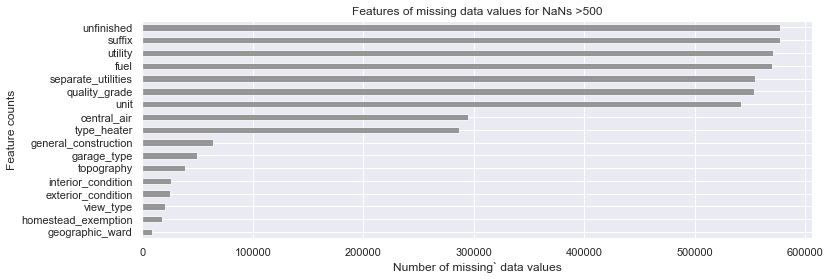

In [229]:
# For the other columns of data features, take a look at how many of them are missing
missing_data = phi_pp_df_2.isnull().sum()
missing_data = missing_data[missing_data > 500]
missing_data.sort_values(inplace=True)
missing_data.plot.barh(color='gray', alpha = 0.8, figsize=(12,4))
plt.title('Features of missing data values for NaNs >500')
plt.ylabel('Feature counts')
plt.xlabel('Number of missing` data values')
# The 'unfinished', 'suffix', 'utility' 'fuel' and separate_utilitites, are the top 5 missing value features.
# Later, we will look into these data see find meaningful substitutions

### House Types Data

In [230]:
# we will study each features in the data set
# When we see a house, we will consider the type of house, such as residental, commercial, industrial?
# Next, we will deep into the 'category_code of these propreties'

category_code_description_count = phi_pp_df_2['category_code_description'].value_counts(dropna=False)

In [231]:
category_code_description_count

Single Family    461199
Vacant Land       44127
Multi Family      42314
Mixed Use         14356
Commercial        13964
Industrial         4326
Name: category_code_description, dtype: int64

In [232]:
#Since the project focuses on residetnial house, we remove the 
# 'Vacant Land (6)', 'Commerical (4)' and 'Industrial (5)' data
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.category_code_description == 'Vacant Land'].index)

In [233]:
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.category_code_description == 'Commercial'].index)

In [234]:
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.category_code_description == 'Industrial'].index)

In [235]:
category_code_count = phi_pp_df_2['category_code_description'].value_counts(dropna=False)

In [236]:
category_code_count
#Now, only 'Single Family', 'Multi Family', and 'Mixed Use' Category left

Single Family    461199
Multi Family      42314
Mixed Use         14356
Name: category_code_description, dtype: int64

In [237]:
# The dataset volumns reduce again
phi_pp_df_2.shape

(517869, 44)

Text(0.5, 1.0, 'market_value vs type of houses')

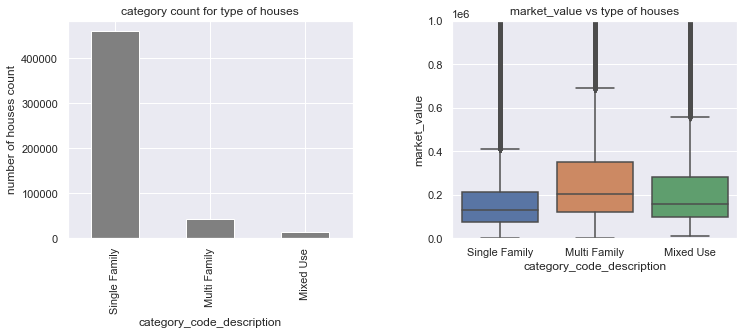

In [238]:
#Next, we will deep into these three catagories. Seaborn Plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), gridspec_kw={'wspace':0.35})

category_code_plots = phi_pp_df_2.category_code_description.value_counts()
category_code_plots.plot.bar(ax = ax1, color = 'gray')
ax1.set_title('category count for type of houses')
ax1.set_xlabel('category_code_description')
ax1.set_ylabel('number of houses count')


category_df = pd.concat([phi_pp_df_2['market_value'],
                       phi_pp_df_2['category_code_description']], axis = 1)
box_fig = sns.boxplot(x='category_code_description', y='market_value', data=category_df, ax=ax2)
box_fig.axis(ymin=0, ymax=1000000)
ax2.set_title('market_value vs type of houses')

In [239]:
# The boxplot result show that Multi Family has better average market value than Mixed Use family

### House Value with Geographic Data

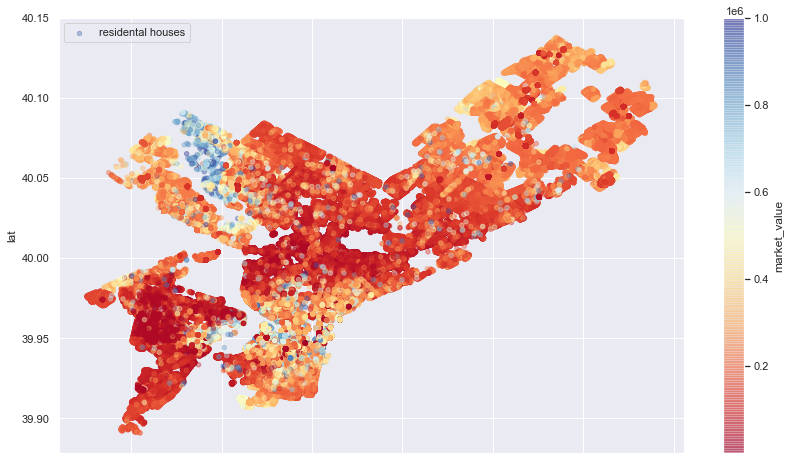

In [240]:
# Next, look at the geographic featurem since we have longitude and latitude data. 
# Herem we filter the value more than $1,000,000
geo_phi_pp_vis = phi_pp_df_2[phi_pp_df_2.market_value <= 1000000].plot(kind='scatter', x='lng', y='lat', 
                label='residental houses',c='market_value', cmap=plt.get_cmap('RdYlBu'), 
                colorbar=True, alpha=0.4, figsize=(14,8))
geo_phi_pp_vis.legend()

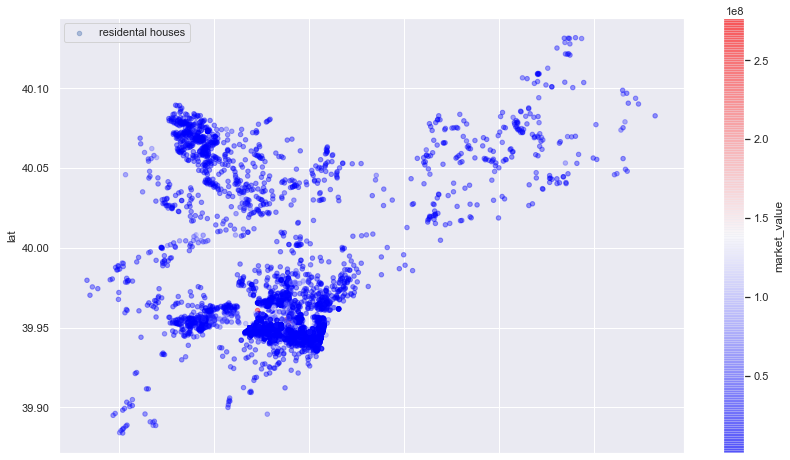

In [241]:
# Show the distribution of houses with market value greater than $1,000,000
geo_phi_pp_vis = phi_pp_df_2[phi_pp_df_2.market_value > 1000000].plot(kind='scatter', x='lng', y='lat',
                label='residental houses',c='market_value', cmap=plt.get_cmap('bwr'), 
                colorbar=True, alpha=0.4, figsize=(14,8))
geo_phi_pp_vis.legend()

#### Based on the geodata, the houses locate at Center Philly and the Northwest Phily has the higher market vaule.

In [242]:
# Next, look at the zipcode, some of the zipcode contains "-", and the data type for 'zip_code' is string
phi_pp_df_2.zip_code.value_counts().sum()

517869

In [243]:
phi_pp_df_2.zip_code.dtypes

dtype('O')

In [244]:
#Only keep the first five digit for the zipcode, Philadephia Zipcode range 19102 - 10154
phi_pp_df_2['zip_code'] = phi_pp_df_2['zip_code'].str[:5]

In [245]:
phi_pp_df_2['zip_code'].head()

0    19147
1    19147
2    19147
3    19147
6    19148
Name: zip_code, dtype: object

In [246]:
phi_pp_df_2.head()

index        lng  building_code_description  category_code  \
0      0 -75.147676          ROW 2 STY MASONRY              1   
1      1 -75.147126          ROW 3 STY MASONRY              1   
2      2 -75.147169          ROW 3 STY MASONRY              1   
3      3 -75.147223    ROW W/GAR 4 STY MASONRY              1   
6      6 -75.147688  ROW W/GAR 3 STY MAS+OTHER              1   

  category_code_description central_air  depth  exempt_building  exempt_land  \
0             Single Family           N  32.00              0.0          0.0   
1             Single Family           N  46.75              0.0          0.0   
2             Single Family           N  46.75         141800.0          0.0   
3             Single Family           Y  39.87              0.0          0.0   
6             Single Family           Y  84.00         490932.0          0.0   

   exterior_condition  ...  total_livable_area  type_heater unfinished  unit  \
0                 4.0  ...               840.0            H       None  None   
1                 4.0  ...               925.0            H       None  None   
2                 4.0  ...               870.0            H       None  None   
3                 1.0  ...              3040.0            A       None  None   
6                 1.0  ...              2556.0            A       None  None   

  utility view_type  year_built  zip_code        lat number_of_bedrooms  
0    None         I        1920     19147  39.930378                3.0  
1    None         I        1920     19147  39.930064                2.0  
2    None         I        1920     19147  39.930070                2.0  
3       A         I        2019     19147  39.930086                4.0  
6       A         I        2014     19148  39.930081                3.0  

[5 rows x 44 columns]

In [247]:
phi_pp_df_2.describe().round(2)

index        lng  category_code      depth  exempt_building  \
count  517869.00  517862.00      517869.00  517869.00     5.178690e+05   
mean   286957.93     -75.14           1.14      85.27     4.818079e+04   
std    164511.36       0.07           0.42    1365.34     8.322816e+05   
min         0.00     -75.27           1.00       0.00     0.000000e+00   
25%    145560.00     -75.18           1.00      58.00     0.000000e+00   
50%    290591.00     -75.15           1.00      77.15     2.000000e+04   
75%    424860.00     -75.10           1.00     100.00     4.500000e+04   
max    581455.00     -74.96           3.00  544500.00     1.712097e+08   

       exempt_land  exterior_condition  fireplaces      frontage  \
count    517869.00           517835.00   517868.00  5.178690e+05   
mean       1867.09                3.87        0.04  1.063200e+03   
std      128339.71                0.74        0.25  6.141487e+05   
min           0.00                0.00        0.00  0.000000e+00   
25%           0.00                4.00        0.00  1.500000e+01   
50%           0.00                4.00        0.00  1.600000e+01   
75%           0.00                4.00        0.00  2.000000e+01   
max    69930716.00                7.00        5.00  4.320260e+08   

       garage_spaces  ...  off_street_open  quality_grade    sale_price  \
count      517868.00  ...        517867.00       25303.00  5.178690e+05   
mean            0.38  ...             0.12           3.65  2.953371e+05   
std             0.83  ...             1.04           0.72  1.153651e+07   
min             0.00  ...             0.00           0.00  0.000000e+00   
25%             0.00  ...             0.00           3.00  1.000000e+00   
50%             0.00  ...             0.00           4.00  4.750000e+04   
75%             1.00  ...             0.00           4.00  1.400000e+05   
max            95.00  ...            99.00           6.00  9.487291e+08   

       street_code  taxable_building  taxable_land  total_area  \
count    517869.00      5.178690e+05     517869.00   517869.00   
mean      53959.40      1.265676e+05      43272.33     2168.01   
std       24530.81      8.950363e+05     251204.41    11297.21   
min       11020.00      0.000000e+00          0.00        0.00   
25%       32120.00      3.918500e+04      12420.00      895.80   
50%       54640.00      8.072000e+04      22779.00     1280.00   
75%       76580.00      1.358550e+05      46101.00     1993.16   
max       89750.00      2.492028e+08   50914340.00  5248824.00   

       total_livable_area        lat  number_of_bedrooms  
count           517868.00  517862.00           517868.00  
mean              1718.91      40.00                2.25  
std               8596.72       0.05                1.60  
min                  0.00      39.88                0.00  
25%               1080.00      39.96                0.00  
50%               1260.00      40.00                3.00  
75%               1592.00      40.04                3.00  
max            2445358.00      40.14               93.00  

[8 rows x 27 columns]

In [248]:
phi_pp_df_2.shape

(517869, 44)

In [249]:
# save one copy of dataframe here for Sparks SQL operation at Databicks to join tables with other datasets
phi_pp_df_2.to_csv('../data/phi_pp_df_3.csv')

In [250]:
# Clean some extreme value, market value small less than 10000 and value more than 5000000 will be removed
phi_pp_df_2 = phi_pp_df_2[(phi_pp_df_2['market_value']>10000)&(phi_pp_df_2['market_value']<5000000)]

In [251]:
phi_pp_df_2.shape

(515825, 44)

In [252]:
# Random Sample pixking if need it (by fraction, we randomly select 30% of sample to make a demonstration to look
# at the price distribution )
fraction_of_row_pp_df_2 = phi_pp_df_2.sample(frac=0.3, random_state = 2)

In [253]:
fraction_of_row_pp_df_2.shape

(154748, 44)

In [254]:
fraction_of_row_pp_df_2.head()

index        lng building_code_description  category_code  \
324493  324493 -75.067558       ROW 2.5 STY MASONRY              1   
371652  371652 -75.157469  S/D CONV APT 2 STY MASON              2   
65040    65040 -75.168221         ROW 2 STY MASONRY              1   
186191  186191 -75.115980         ROW 2 STY MASONRY              1   
23130    23130 -75.232185         ROW 2 STY MASONRY              1   

       category_code_description central_air   depth  exempt_building  \
324493             Single Family           N   70.00              0.0   
371652              Multi Family           N  140.00              0.0   
65040              Single Family           N   60.66              0.0   
186191             Single Family        None   60.00         107435.0   
23130              Single Family        None   87.00              0.0   

        exempt_land  exterior_condition  ...  total_livable_area  type_heater  \
324493          0.0                 5.0  ...               952.0            H   
371652          0.0                 4.0  ...              2040.0            B   
65040           0.0                 4.0  ...              1038.0            H   
186191      31465.0                 4.0  ...              1188.0            H   
23130           0.0                 4.0  ...              1130.0         None   

       unfinished  unit utility view_type  year_built  zip_code        lat  \
324493       None  None    None         I        1920     19137  40.000916   
371652       None  None    None         I        1930     19138  40.066372   
65040        None  None    None         I        1940     19132  40.001205   
186191       None  None    None         I        1875     19125  39.976957   
23130        None  None    None         D        1925     19131  39.976602   

       number_of_bedrooms  
324493                3.0  
371652                4.0  
65040                 3.0  
186191                3.0  
23130                 3.0  

[5 rows x 44 columns]

In [255]:
#Select on the market_value and zip_code column
zip_code_fraction_of_row_pp_df = pd.concat([fraction_of_row_pp_df_2['zip_code'],fraction_of_row_pp_df_2['market_value']], axis=1 )

In [256]:
zip_code_fraction_of_row_pp_df.head(100)

zip_code  market_value
324493    19137       84900.0
371652    19138      150000.0
65040     19132       34800.0
186191    19125      138900.0
23130     19131       68000.0
...         ...           ...
457087    19120      133000.0
340332    19145       94900.0
2599      19147      185200.0
257504    19129       45600.0
380085    19131       63500.0

[100 rows x 2 columns]

In [257]:
zip_code_groupby = zip_code_fraction_of_row_pp_df.groupby('zip_code') #.filter(lambda x:len(x) >10)

In [258]:
#Now can look for the mean price of each zipcode (fraction 30% of total samples)
zip_code_groupby.describe()

market_value                                                     \
                count          mean            std        min        25%   
zip_code                                                                   
19102           555.0  5.457539e+05  519310.367434    27000.0   258600.0   
19103          2110.0  6.894228e+05  633630.928918    27500.0   294550.0   
19104          2669.0  2.426296e+05  320233.098213    10100.0    59700.0   
19106          1893.0  5.191867e+05  515278.680077    13500.0   249400.0   
19107          1160.0  4.521032e+05  485612.732130    29000.0   154500.0   
19110             1.0  2.438400e+06            NaN  2438400.0  2438400.0   
19111          5582.0  1.908891e+05  147903.777423    10400.0   141700.0   
19114          2939.0  2.059407e+05   60868.528464    11800.0   188000.0   
19115          2981.0  2.409745e+05  127554.655613    60300.0   196500.0   
19116          2909.0  2.452636e+05   83544.501717    40000.0   214500.0   
19118           787.0  5.823196e+05  378072.893194    26500.0   344100.0   
19119          2780.0  2.661399e+05  254249.102595    25000.0   142600.0   
19120          6127.0  9.612171e+04   37722.853224    11100.0    75850.0   
19121          3418.0  1.540916e+05  201985.689825    10300.0    42800.0   
19122          1687.0  2.126640e+05  243093.498174    11200.0   113050.0   
19123          1554.0  4.170183e+05  328218.562533    20000.0   260925.0   
19124          6192.0  9.857894e+04   58277.491239    11500.0    74500.0   
19125          3194.0  2.521972e+05  174971.849569    11600.0   160100.0   
19126          1432.0  1.681096e+05  175380.426313    10500.0   116800.0   
19127           839.0  2.684622e+05  257372.476642    19200.0   197500.0   
19128          3805.0  2.512455e+05  131752.016103    12800.0   204300.0   
19129          1178.0  2.149481e+05  229561.796592    10800.0   132775.0   
19130          2951.0  4.011092e+05  282145.037568    16500.0   240500.0   
19131          3919.0  1.030403e+05  102825.440614    11300.0    59000.0   
19132          4641.0  4.450215e+04   72925.984322    10100.0    28000.0   
19133          2595.0  4.720913e+04   81993.074612    10200.0    28100.0   
19134          6511.0  8.186245e+04   61147.571075    10100.0    39400.0   
19135          3400.0  1.234151e+05   81843.312909    11200.0   100775.0   
19136          3179.0  1.614310e+05   97380.574088    10800.0   122300.0   
19137          1025.0  1.481981e+05   47703.553025    11200.0   120500.0   
19138          3582.0  1.097638e+05   89227.995794    11900.0    79950.0   
19139          4444.0  9.288841e+04  139779.895315    10100.0    51600.0   
19140          5633.0  5.283337e+04   85920.555649    10100.0    37400.0   
19141          2850.0  1.069396e+05  127908.349570    10600.0    84300.0   
19142          3162.0  7.762268e+04   28544.423628    11600.0    66100.0   
19143          6988.0  1.063766e+05  135940.942286    11700.0    56700.0   
19144          3483.0  1.408935e+05  246711.835362    10100.0    75800.0   
19145          5400.0  1.810562e+05  123558.699176    19900.0   103000.0   
19146          5525.0  3.141006e+05  255653.083558    18000.0   117400.0   
19147          4681.0  4.243614e+05  245631.006123    16100.0   268300.0   
19148          5983.0  2.072602e+05   82892.304524    21200.0   156700.0   
19149          5474.0  1.415698e+05   44954.886818    32300.0   123925.0   
19150          2752.0  1.520636e+05  134396.108332    58700.0   125400.0   
19151          3283.0  1.356448e+05   76550.358814    17900.0    99800.0   
19152          2997.0  2.128523e+05  124574.537873    32000.0   191600.0   
19153          1035.0  1.325290e+05  120659.621921    15200.0   103300.0   
19154          3463.0  2.105307e+05  121759.803379    38200.0   198400.0   

                                           
                50%        75%        max  
zip_code                                   
19102      351500.0   639800.0  4139000.0  
19103      489100.0   879250.0  

### From the table above , we can see the the market value has very large difference even in the same zipcode. For data visualization, please see the 'phi_house_data_vis.ipynb' notebook.

In [148]:
# Next, Look for something ineteresting by wordcount
phi_pp_df_2['zip_code'].head()

0    19147
1    19147
2    19147
3    19147
6    19148
Name: zip_code, dtype: object

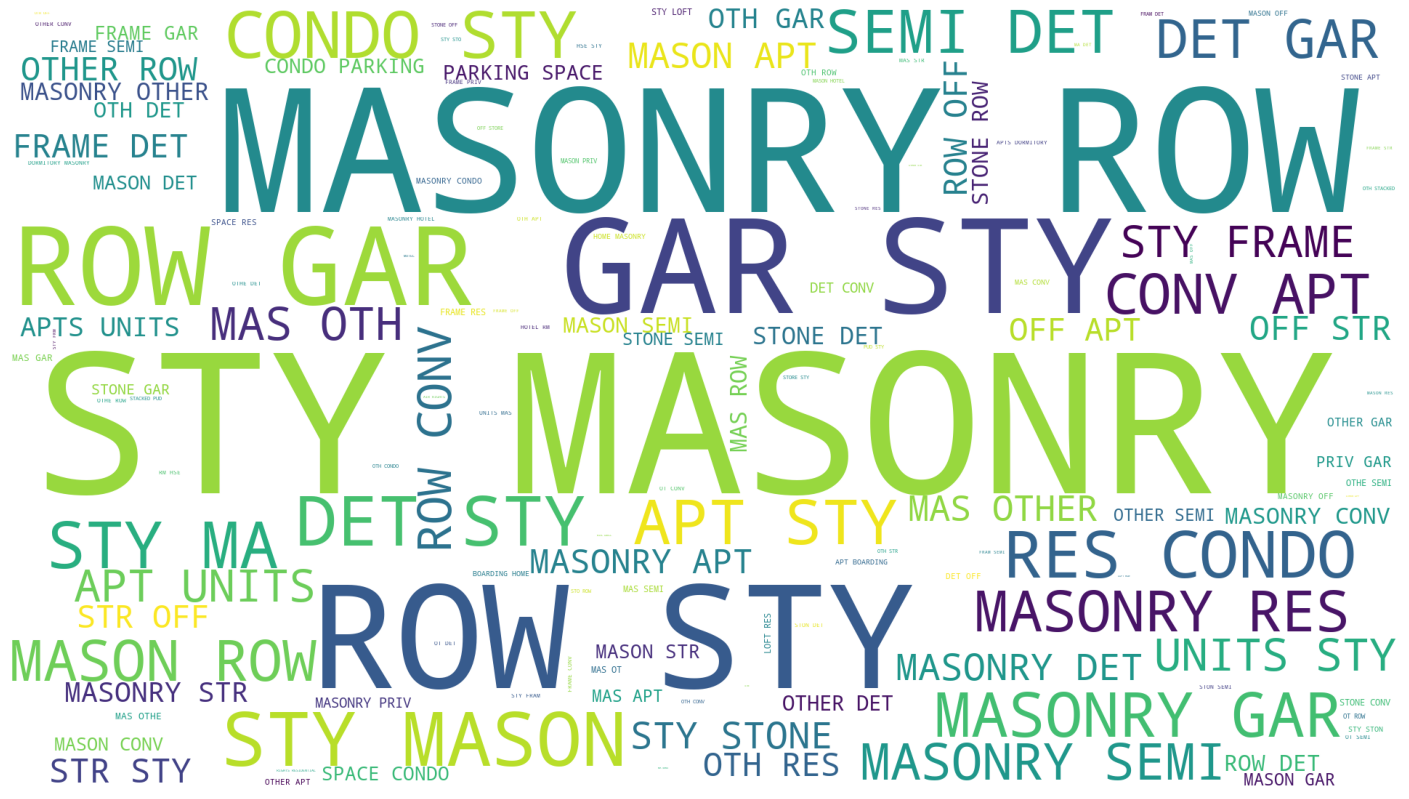

In [149]:
# House description wordcount based on 30% of the total samples
plt.subplots(figsize = (25, 15))
wordcloud=WordCloud(background_color = 'white', 
                    width = 1920, 
                    height = 1080
                    ).generate(" ".join(phi_pp_df_2.building_code_description))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# The result show that most house/ building type belong to story mansory
# STY: Story, GAR: Gargage, 

In [ ]:
# For the total samples results, please see the spark session and summary dataset. All samples will be grouby zip_code
# and applying the average value on zip_code result.

#### Next, we go to see the correlation of other features, such as basement, type_heater, central_air,fuel and more. The samples are based on the whole cleaned dataset

In [150]:
# Clean some un-make sense features that might affect for the house value prediction
# Drop 'depth' column that depth = 0
phi_pp_df_2 = phi_pp_df_2.drop(phi_pp_df_2[phi_pp_df_2.depth == 0].index)

In [151]:
phi_pp_df_2.shape

(482167, 44)

In [152]:
phi_pp_df_2.head()

index        lng  building_code_description  category_code  \
0      0 -75.147676          ROW 2 STY MASONRY              1   
1      1 -75.147126          ROW 3 STY MASONRY              1   
2      2 -75.147169          ROW 3 STY MASONRY              1   
3      3 -75.147223    ROW W/GAR 4 STY MASONRY              1   
6      6 -75.147688  ROW W/GAR 3 STY MAS+OTHER              1   

  category_code_description central_air  depth  exempt_building  exempt_land  \
0             Single Family           N  32.00              0.0          0.0   
1             Single Family           N  46.75              0.0          0.0   
2             Single Family           N  46.75         141800.0          0.0   
3             Single Family           Y  39.87              0.0          0.0   
6             Single Family           Y  84.00         490932.0          0.0   

   exterior_condition  ...  total_livable_area  type_heater unfinished  unit  \
0                 4.0  ...               840.0            H       None  None   
1                 4.0  ...               925.0            H       None  None   
2                 4.0  ...               870.0            H       None  None   
3                 1.0  ...              3040.0            A       None  None   
6                 1.0  ...              2556.0            A       None  None   

  utility view_type  year_built  zip_code        lat number_of_bedrooms  
0    None         I        1920     19147  39.930378                3.0  
1    None         I        1920     19147  39.930064                2.0  
2    None         I        1920     19147  39.930070                2.0  
3       A         I        2019     19147  39.930086                4.0  
6       A         I        2014     19148  39.930081                3.0  

[5 rows x 44 columns]

In [153]:
# drop the index column since not relative to market_value
phi_pp_df_2 = phi_pp_df_2.drop(['index'], axis = 1)

In [154]:
phi_pp_df_2.shape

(482167, 43)

<Figure size 2160x2160 with 0 Axes>

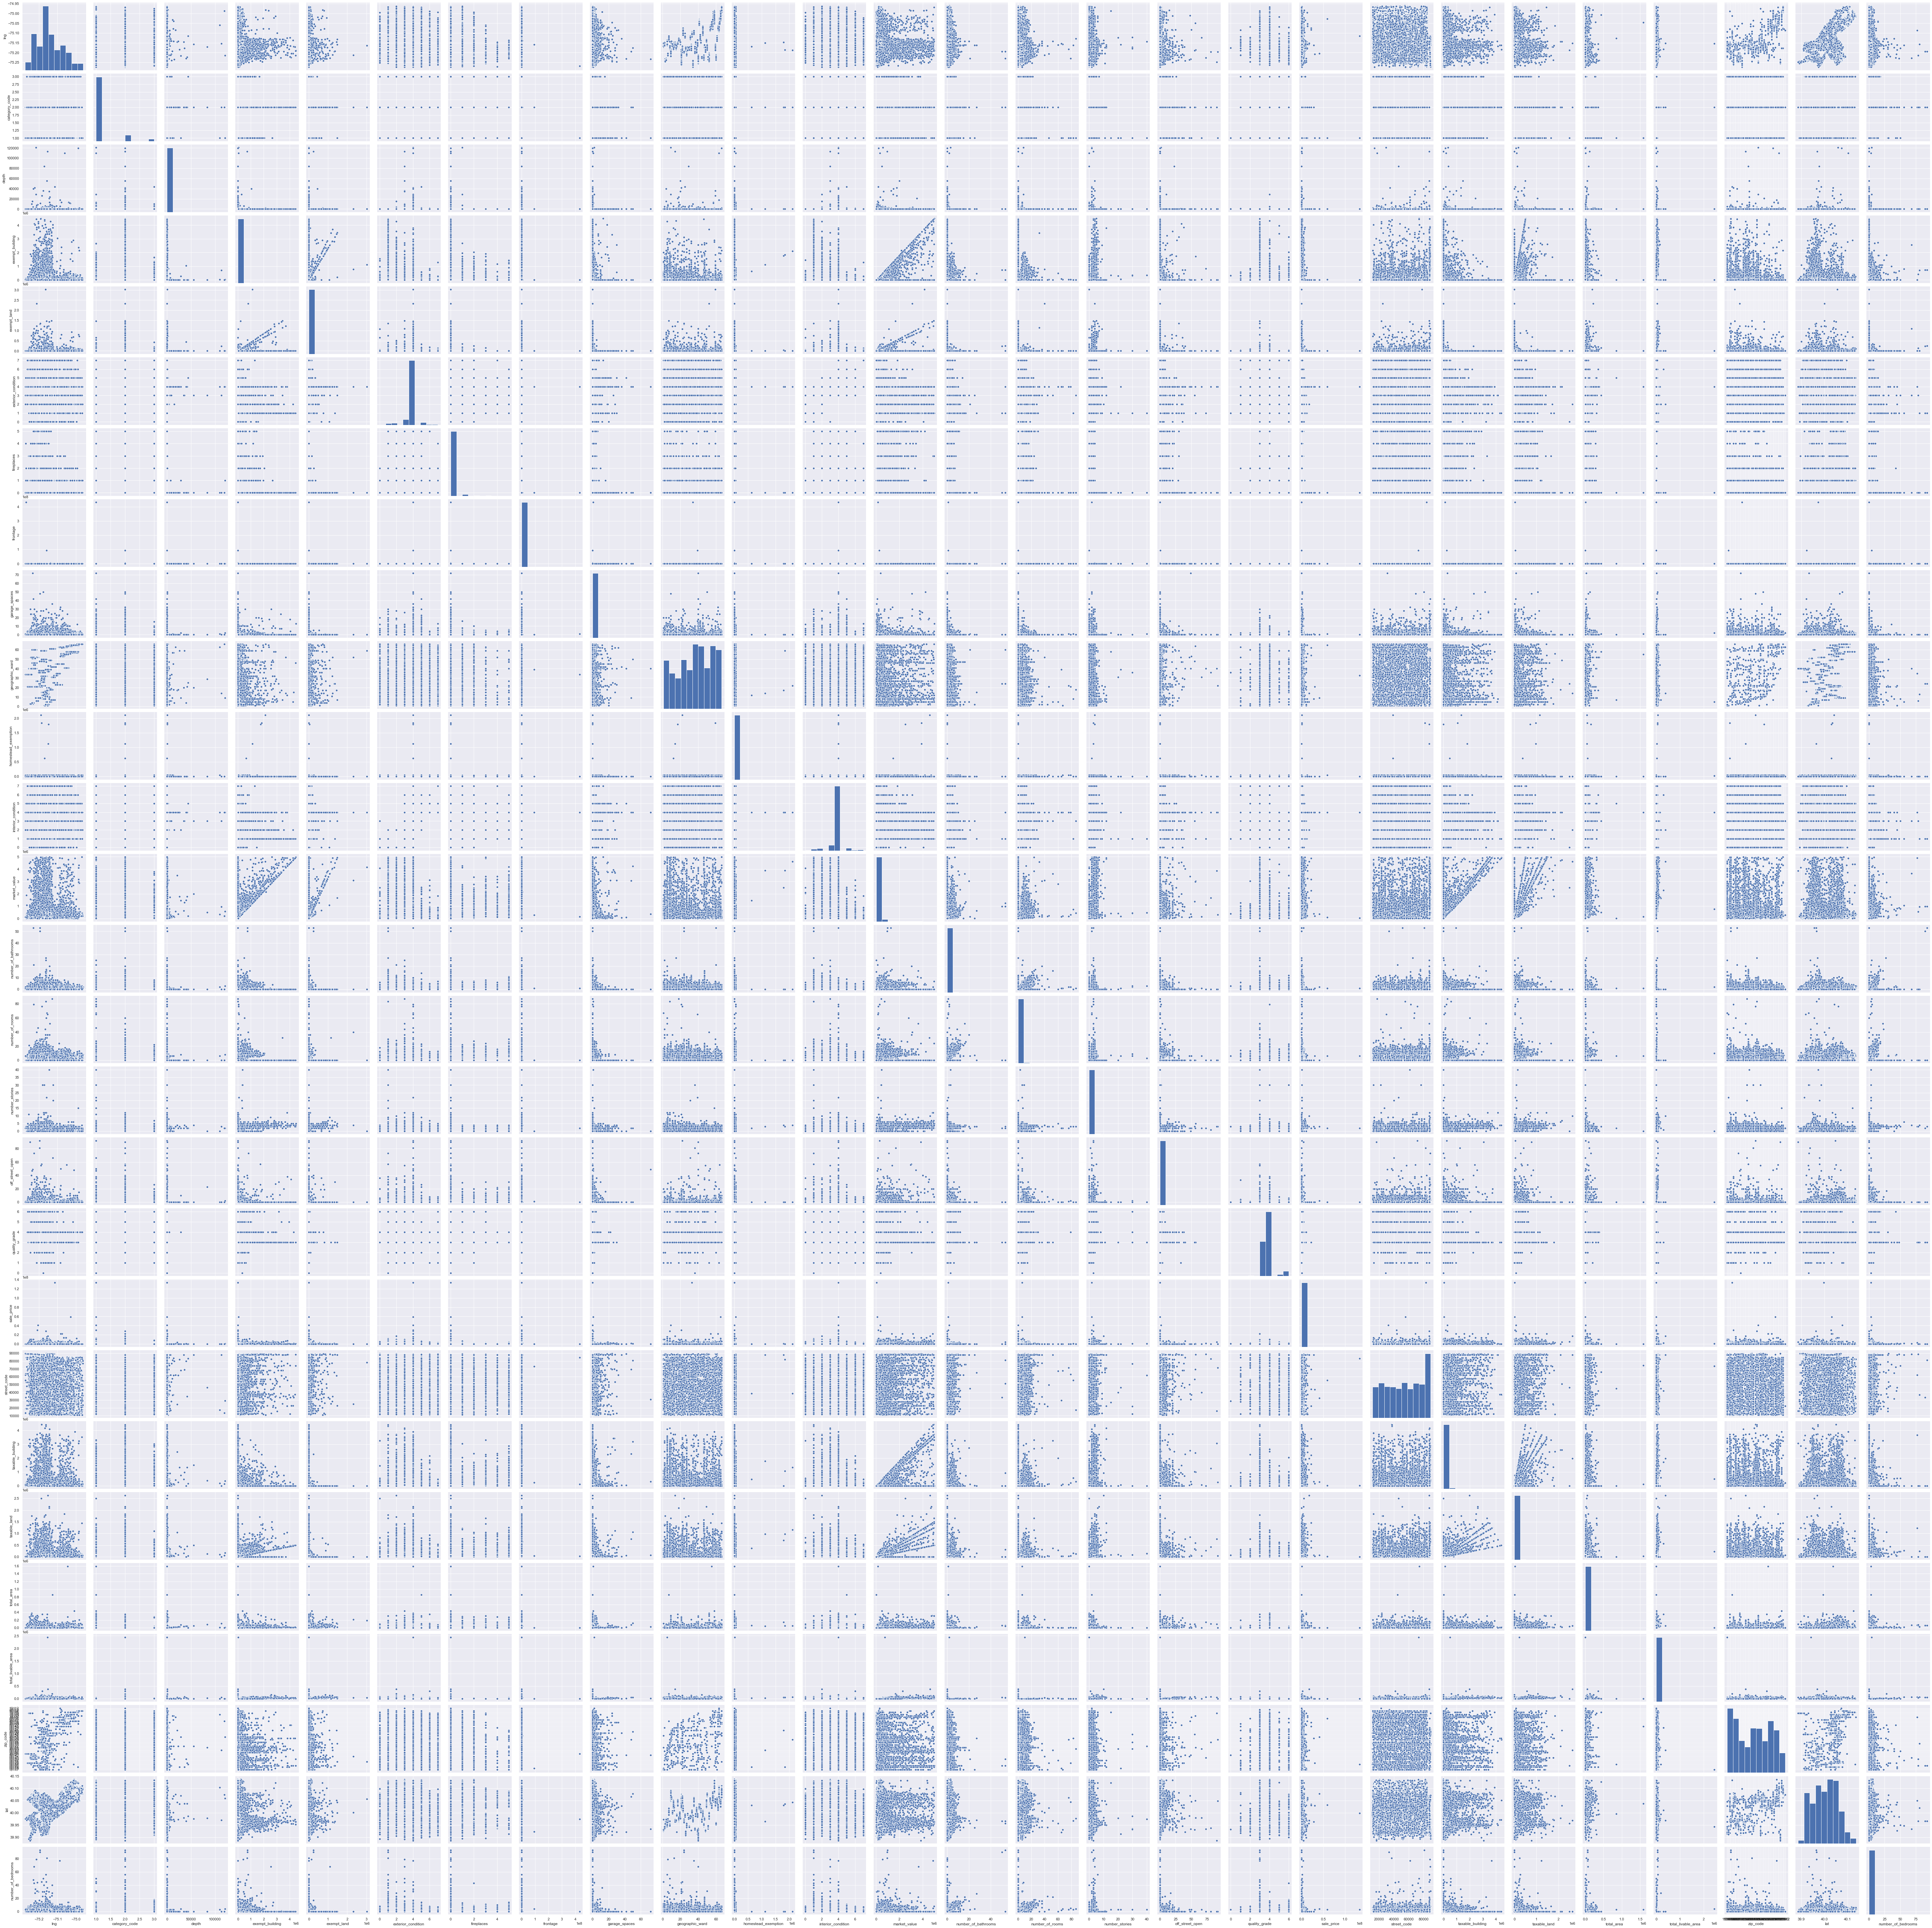

In [155]:
#Let's use the pairplot to see the big picture of all the correlation
plt.figure(figsize=(30, 30))
sns.pairplot(phi_pp_df_2, height =3, diag_kind='auto')

In [156]:
corr_phi_pp_df_2 = phi_pp_df_2.corr()

In [157]:
#Let's look at the correlation 
corr_phi_pp_df_2.sort_values(['market_value'], ascending = False, inplace = True)
print('Feature correlation relative to the market_value:')
print(corr_phi_pp_df_2.market_value)

Feature correlation relative to the market_value:
market_value           1.000000
taxable_land           0.918580
taxable_building       0.825787
exempt_building        0.489318
sale_price             0.340918
total_area             0.307352
total_livable_area     0.297996
fireplaces             0.239865
number_stories         0.184496
category_code          0.182870
off_street_open        0.166192
exempt_land            0.157256
garage_spaces          0.106242
number_of_bathrooms    0.038153
depth                  0.033675
lng                    0.020515
street_code            0.010078
frontage               0.000165
homestead_exemption   -0.001880
lat                   -0.050803
quality_grade         -0.077824
number_of_bedrooms    -0.115846
geographic_ward       -0.123294
number_of_rooms       -0.178801
exterior_condition    -0.341885
interior_condition    -0.342323
Name: market_value, dtype: float64


#### Now, we can see that, the top 5 relative features with market_value are : 
#### 1. taxable_land, 2. taxable_buliding, 3. exempt_building, 4. sale_price, 5. total_area

In [159]:
phi_pp_df_2_for_corr_vis = corr_phi_pp_df_2.corr()

Text(0.5, 1.0, 'Heatmap of features with market_vaule')

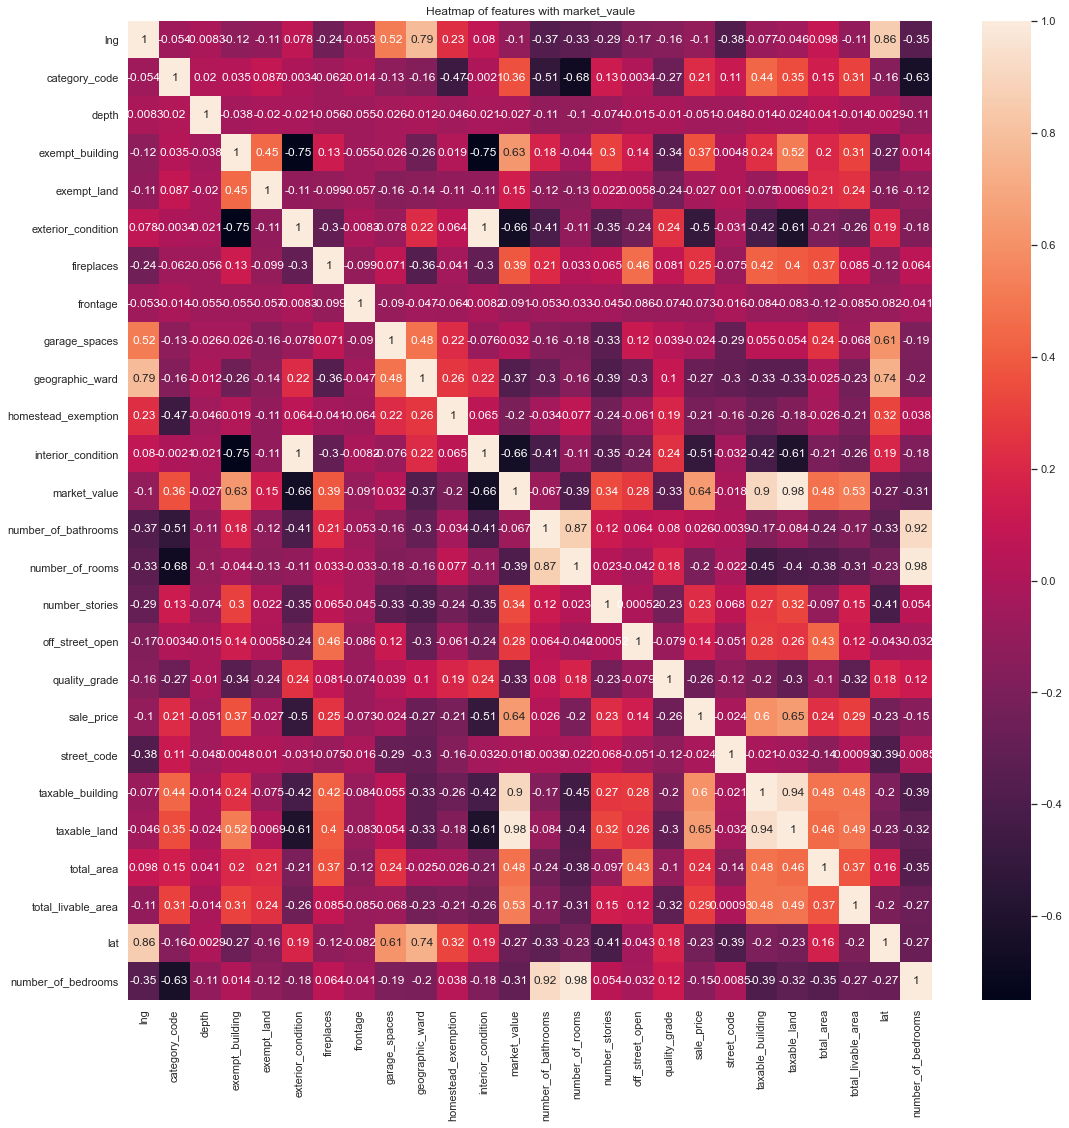

In [160]:
#Let's visualize this correlation
sns.set(font_scale =1)
corr_vis = phi_pp_df_2_for_corr_vis
cols = corr_vis.nlargest(18, 'market_value')['market_value'].index
# phi_pp_df_2_for_corr_vis=np.corrcoef(phi_pp_df_2_for_corr_vis[cols].values.T)
plt.figure(figsize =(18, 18))
ax = sns.heatmap(phi_pp_df_2_for_corr_vis, annot=True)
ax.set_title("Heatmap of features with market_vaule")

### Combined the observation for pairplot and heatmap correlation plot, we found some of the feature has close relationship with market_value, such as number_of_bathroom, number_of_room, taxable_building, taxable_building. In the future study, we are going to build a linear regression model to train and text this dataset.

### Please see the spark session for join table operation on this main properties public dataset (phi_pp_df_3.csv) join with the other dataset (SPARK-SQL will be applied in the Spark Session)